In [1]:
import mne
import semopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from utils import *
import shap
import seaborn as sns
from tqdm import tqdm
import pingouin as pg
import pandas as pd
import scipy
import statannot
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import pi
from sklearn.metrics import r2_score
from mne.stats import bonferroni_correction, fdr_correction
# Say, "the default sans-serif font is COMIC SANS"
mpl.rcParams['font.sans-serif'] = "Times New Roman"
mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.serif'] = ['Times New Roman']
import warnings
warnings.filterwarnings('ignore')

/home/xiaowei/miniconda3/envs/bci/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
create_folder = lambda folder_name: os.makedirs(folder_name) if not os.path.exists(folder_name) else None
def get_fake_epoch(folder_name,main_path,model_type):
    epoch = loadpkl(main_path + 'preprocessing/' + folder_name + '/final_eye_close_1001_epoch_concat.pkl')
    return epoch
def mappshap(shap_values):
    # input: 4836 as Channel from 0 to 30, after freq from 0 to 155
    # output: (31,156,2)
    shap = np.zeros((31,78,2))
    t = 0
    for s in range(2):
        for i in range(31):
            for j in range(78):
                shap[i,j,s] = shap_values[t]
                t += 1
    return shap

# Feature Importance

Show the difference of subjects

### Define some global paths and parameters

In [3]:
main_path = '/data/xiaowei/social_network/HENU/'
folder_name = 'S42_C30_330_F1_40_N50_E2_Raverage'
model_type = 'XGBRegressor'
method = 'PSD'
seed = 187
EEG_bands = dict(alpha = [8,14],beta = [14,30],theta = [4,8],gamma = [30,40],delta = [1,4])
file_path = '/data/xiaowei/social_network/HENU/figs_final/feature_importance'

### Plot all in one result

In [4]:
import ast
AIO_metric = 'r2_score'
data = pd.read_csv(main_path + 'AIO_regression/' + folder_name + f'/{model_type}_{AIO_metric}.csv')
data = ast.literal_eval(data['value'][0])[seed]
df = pd.DataFrame(columns=['SHAP/Feature Importance','Term','Eye'])
for term in ['final','midterm']:
    for event in ['eye_close','eye_open']:
        key = f'{term}_{event}'
        df = df.append({'SHAP/Feature Importance': data[key], 'Term': term, 'Eye': event}, ignore_index=True)
print(df)

   SHAP/Feature Importance     Term        Eye
0                 0.616478    final  eye_close
1                 0.666095    final   eye_open
2                 0.582628  midterm  eye_close
3                 0.594829  midterm   eye_open


### final and baseline score

In [5]:
Data = loadpkl(main_path + f'AIO_regression_baseline/{folder_name}/'  + f'{model_type}_{method}_{seed}_Dataset.pkl')
model = loadpkl(main_path + f'AIO_regression_baseline/{folder_name}/'  + f'{model_type}_{method}_{seed}_model.pkl')
X_test = Data['X_val']
y_test = Data['y_val']
y_pred = model.predict(X_test)
print(f'Baseline R2: {r2_score(y_test,y_pred)}')
Data = loadpkl(main_path + f'AIO_regression/{folder_name}/'  + f'{model_type}_{method}_{seed}_Dataset.pkl')
model = loadpkl(main_path + f'AIO_regression/{folder_name}/'  + f'{model_type}_{method}_{seed}_model.pkl')
X_test = Data['X_val']
y_test = Data['y_val']
y_pred = model.predict(X_test)
print(f'Final R2: {r2_score(y_test,y_pred)}')


Baseline R2: 0.5489227855479055
Final R2: 0.6151102693333027


### Load Data

In [18]:
create_folder(file_path)
Data = loadpkl(main_path + f'AIO_regression/{folder_name}/'  + f'{model_type}_{method}_{seed}_Dataset.pkl')
model = loadpkl(main_path + f'AIO_regression/{folder_name}/'  + f'{model_type}_{method}_{seed}_model.pkl')
epoch = get_fake_epoch(folder_name = folder_name,main_path = main_path,model_type = model_type)
ch_name = epoch.info['ch_names']
X_test = Data['X_val']
y_test = Data['y_val']
X_key_test = Data['X_key_val']
EEG_featuremap = Data['EEG_featuremap']
shap_values_dict = dict()
shap_scaler_dict = dict()
for term in ['final','midterm']:
    for event in ['eye_close','eye_open']:
        print(f"term: {term}, event: {event}")
        idx = np.isin(X_key_test,f"{term}_{event}_True")+np.isin(X_key_test,f"{term}_{event}_False") != 0
        feature_names_array = np.array(EEG_featuremap[term][event+'_PSD'])[0] # channel+frequency
        feature_names = np.concatenate([np.stack([f"S{subj}_CH{feature_names_array[i][0]:.0f}_F{feature_names_array[i][1]:.2f}" 
                            for i in range(feature_names_array.shape[0])])
                            for subj in ['A','B']])
        psd_idx = np.array(sorted(np.unique(feature_names_array[:,1])))
        explainer = shap.TreeExplainer(model,feature_names=feature_names)
        shap_values = np.abs(explainer.shap_values(X_test[idx]))
        # shap_values = explainer.shap_values(X_test[idx])
        shap_values_organized = np.stack([mappshap(shap_values[i]) for i in range(shap_values.shape[0])]) # (n_sample,31,78,2)
        shap_scaler_dict[f"{term}_{event}"] = {'mean':shap_values_organized.mean(),'std':shap_values_organized.std()}
        for ib,band in enumerate(EEG_bands.keys()):
            idx = (np.array(psd_idx>=EEG_bands[band][0],dtype = np.int32) * np.array(psd_idx<=EEG_bands[band][1],dtype = np.int32)) != 0
            shap_values_dict[f"{term}_{event}_{band}"] = shap_values_organized[:,:,idx,:] #(n_sample,31,n_freq,2)

term: final, event: eye_close
term: final, event: eye_open
term: midterm, event: eye_close
term: midterm, event: eye_open


In [22]:
for term in ['final','midterm']:
    for event in ['eye_close','eye_open']:
        print(f"term: {term}, event: {event}")
        idx = np.isin(X_key_test,f"{term}_{event}_True")+np.isin(X_key_test,f"{term}_{event}_False") != 0
        feature_names_array = np.array(EEG_featuremap[term][event+'_PSD'])[0] # channel+frequency
        feature_names = np.concatenate([np.stack([f"S{subj}_CH{feature_names_array[i][0]:.0f}_F{feature_names_array[i][1]:.2f}" 
                            for i in range(feature_names_array.shape[0])])
                            for subj in ['A','B']])
        psd_idx = np.array(sorted(np.unique(feature_names_array[:,1])))
        explainer = shap.TreeExplainer(model,feature_names=feature_names)
        shap_values = explainer.shap_values(X_test[idx])
        shap.dependence_plot(0,feature_names[0], shap_values, X_test[idx])


term: final, event: eye_close


TypeError: string indices must be integers

### Channel Select and plot topo map for Band {2 layers}

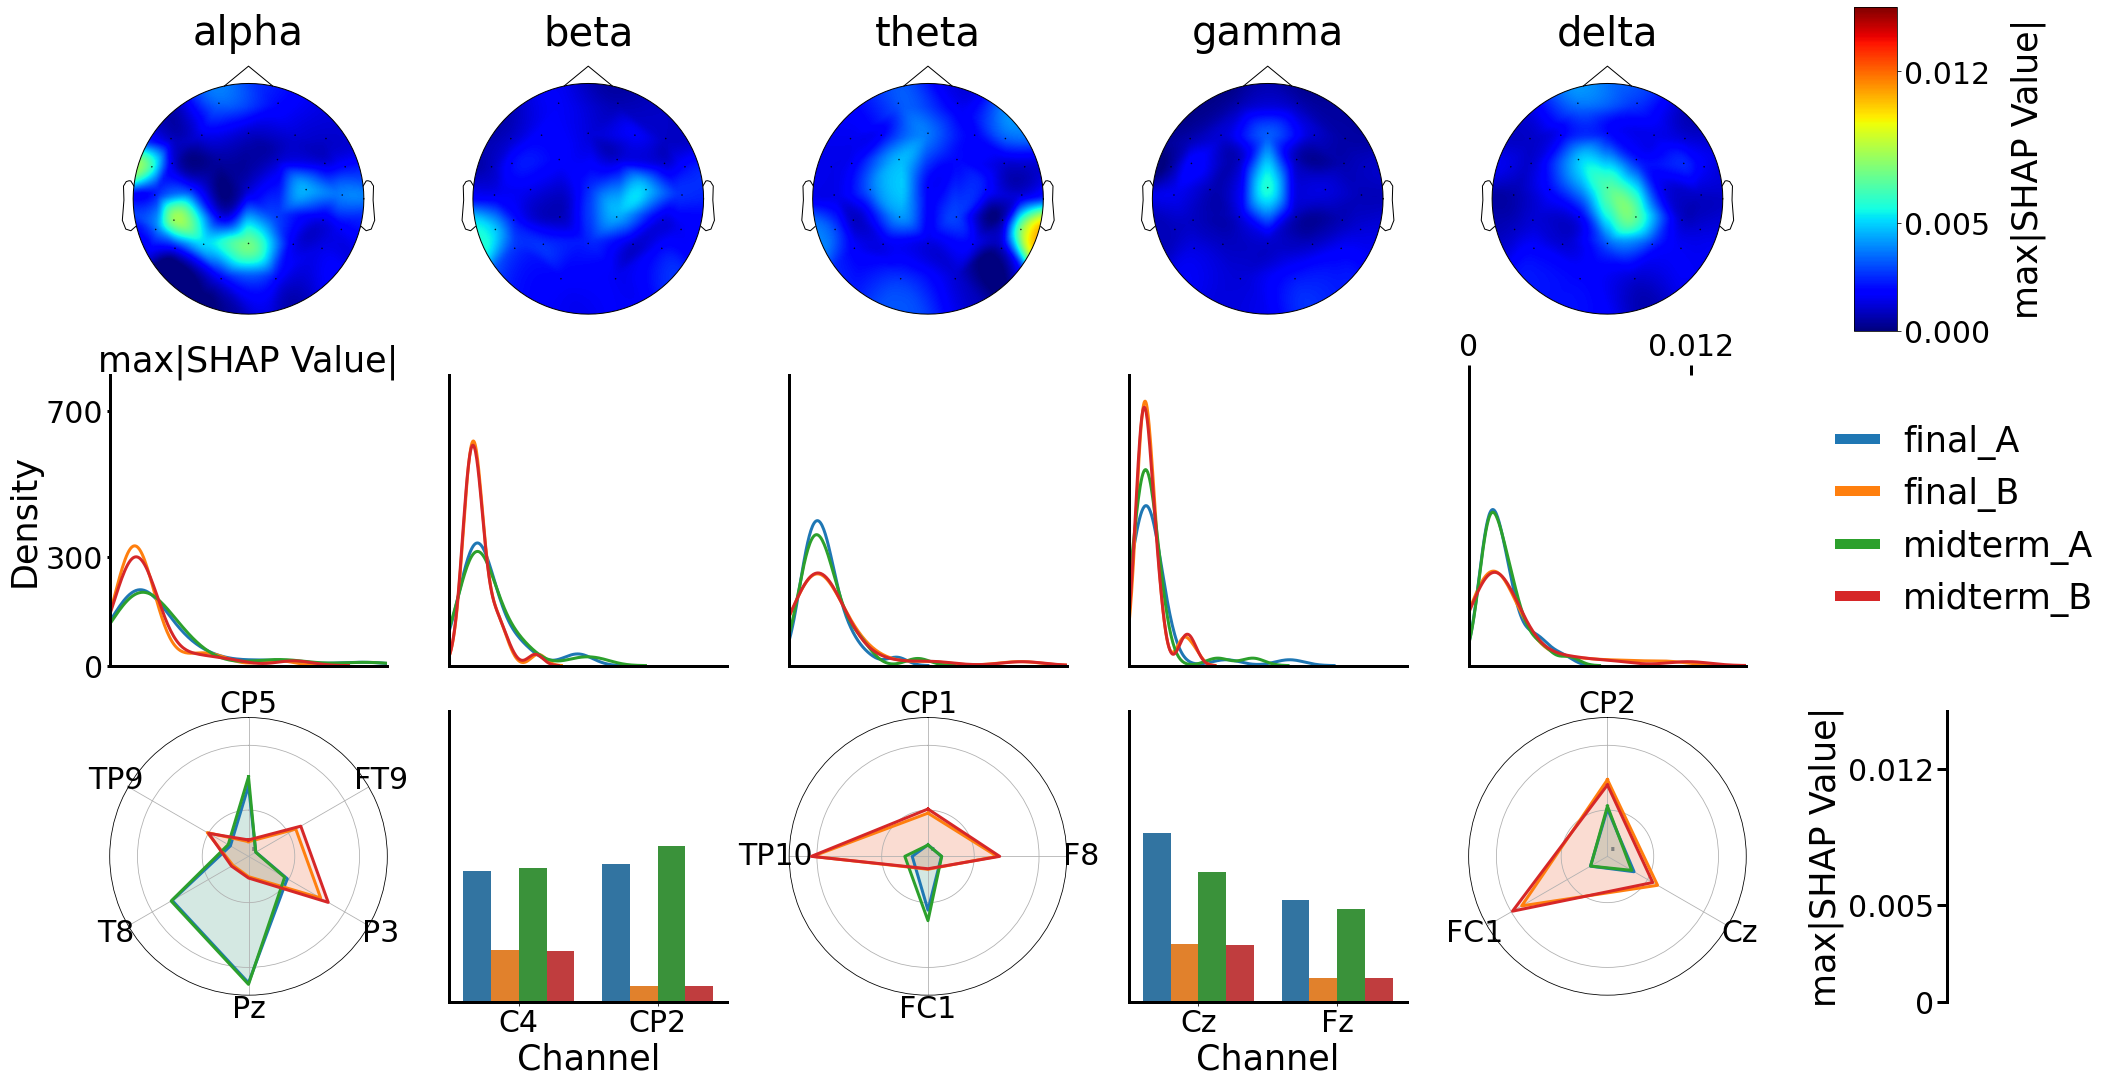

In [19]:
from turtle import width

vmax = 0.015
vmin = 0
fontsize_label = 35
fontsize_tick = 30
fontsize_title = 40
fig1 = plt.figure(figsize=(30,15))
csfont = {'fontname':'Times New Roman'}
df = pd.DataFrame(columns=['SHAP/Feature Importance','channel','band'])
for ib,band in enumerate(EEG_bands.keys()):
    data_band = []
    for term in ['final','midterm']:
        for event in ['eye_close','eye_open']:
            data = shap_values_dict[f"{term}_{event}_{band}"] #(n_sample,31,n_freq,2)
            n_freq = data.shape[2]
            data = data.mean(0).sum(1).mean(1) #(31,)
            # data = (data - shap_scaler_dict[f"{term}_{event}"]['mean']) / shap_scaler_dict[f"{term}_{event}"]['std']
            data_band.append(data/n_freq)
            # data_band.append(data.sum(0))
    data_band = np.stack(data_band)
    data_avg = data_band.max(0)
    # data_avg = minmax_peak(data_band)
    ax = plt.subplot(3,6,ib+1)
    im,cn = mne.viz.plot_topomap(data = data_avg,pos = epoch.info,
                    names = epoch.info['ch_names'],
                    show_names = False,
                    vmin = vmin, vmax = vmax,
                    cmap = 'jet',
                    show = False,axes = ax,
                    contours = 0)
    plt.title(f'{band}',rotation = 0,fontsize = fontsize_title,**csfont)
    band_list = np.repeat(band,31)
    df = df.append(pd.DataFrame(np.stack([data_avg,ch_name,band_list]).T,columns=['SHAP/Feature Importance','channel','band']))
ax_x_start = 0.86
ax_x_width = 0.02
ax_y_start = 0.7
ax_y_height = 0.3
cbar_ax = fig1.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
# cbar_ax = plt.subplot(3,6,6)
bounds = [0,0.005,0.012]
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig1.colorbar(im,cax=cbar_ax,orientation='vertical',ticks = bounds)
cbar.set_label(label='max|SHAP Value|',fontsize= fontsize_label,**csfont,rotation = 90,labelpad = 20)
cbar.ax.tick_params(labelsize=fontsize_tick)
# plt.tight_layout()
# plt.savefig(file_path + f'/{folder_name}_{model_type}_{method}_{seed}_OnlyBand_shap.png',dpi = 1000)
# print(df)
df.to_csv(file_path + f'/{folder_name}_{model_type}_{method}_{seed}_OnlyBand_shap.csv',index = None)


thr = 0.005
df = pd.DataFrame(columns=['SHAP/Feature Importance','channel','band','term','subj'])
for ib,band in enumerate(EEG_bands.keys()):
    
    for term in ['final','midterm']:
        data_term = []
        for event in ['eye_close','eye_open']:
            data = shap_values_dict[f"{term}_{event}_{band}"] #(n_sample,31,n_freq,2)
            n_freq = data.shape[2]
            data = data.mean(0).sum(1) #(31,2)
            data_term.append(data/n_freq)
        data_term = np.stack(data_term).max(0) #(31,2)
        for isubj,subj in enumerate(['A','B']):
            for ch in range(31):
                df = df.append(pd.DataFrame([[data_term[ch,isubj],ch_name[ch],band,term,subj]],columns=['SHAP/Feature Importance','channel','band','term','subj']))
# plot kdensity
csfont = {'fontname':'Times New Roman'}
for ib,band in enumerate(EEG_bands.keys()):
    ax = plt.subplot(3,6,6+ib+1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    # plot kde for each subject and term
    for term in ['final','midterm']:
        for subj in ['A','B']:
            data = df[(df['band']==band) & (df['term']==term) & (df['subj']==subj)]['SHAP/Feature Importance'].values
            sns.kdeplot(data,ax = ax,label = f'{term}_{subj}',linewidth = 3)
            plt.xlim([vmin,vmax])
            plt.ylim([0,800])
            if ib == 0:
                ax.xaxis.set_label_position('top')
                plt.ylabel('Density',fontsize = fontsize_label,**csfont)
                plt.yticks([0,300,700],fontsize = fontsize_tick,**csfont)
                plt.xlabel('max|SHAP Value|',fontsize = fontsize_label,**csfont)
                
                ax.yaxis.set_tick_params(width=3)
            else:
                plt.yticks([])
                plt.ylabel('')
                plt.xlabel('')
            if ib == len(EEG_bands.keys())-1:
                ax.xaxis.tick_top()
                ax.xaxis.set_tick_params(width=3,length=10)
                plt.xticks([0,0.012],['0','0.012'],fontsize = fontsize_tick,**csfont)
            else:
                plt.xticks([])
ax_legend = plt.subplot(3,6,12)
plt.xlabel('')
plt.xticks([])
plt.yticks([])
plt.ylabel('')
ax_legend.spines['right'].set_visible(False)
ax_legend.spines['top'].set_visible(False)
ax_legend.spines['bottom'].set_visible(False)
ax_legend.spines['left'].set_visible(False)
leg = plt.legend(ax.get_legend_handles_labels()[0],ax.get_legend_handles_labels()[1],fontsize = fontsize_label,loc = 'center left', frameon=False,handlelength=1)

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(10)

    
df[df['SHAP/Feature Importance']>=thr].groupby(['band','channel']).mean().to_csv(file_path + f'/{folder_name}_{model_type}_{method}_{seed}_ChannelSelect.csv')
sub_df = pd.read_csv(file_path + f'/{folder_name}_{model_type}_{method}_{seed}_ChannelSelect.csv')
for ib,band in enumerate(EEG_bands.keys()):
    categories=list(sub_df[sub_df['band']==band]['channel'])
    N = len(categories)
    if N>2:
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]
        ax = plt.subplot(3,6,12+ib+1, polar=True)
        
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        plt.xticks(angles[:-1], categories,fontsize = fontsize_tick,**csfont)
        ax.set_rlabel_position(0)
        plt.yticks([0,0.005,0.012], ['.','',''], color="grey",size = fontsize_tick,**csfont)
        plt.ylim(0,0.015)
  
    # ------- PART 2: Add plots
    
        # Plot each individual = each line of the data
        # I don't make a loop, because plotting more than 3 groups makes the chart unreadable
        for term in ['final','midterm']:
            for isubj,subj in enumerate(['A','B']):
                values=df[(df['band']==band) & (df['term']==term) & (df['subj']==subj)]['SHAP/Feature Importance'].values.flatten().tolist()
                values = [v for i,v in enumerate(values) if ch_name[i] in categories]
                values += [values[0]]
                ax.plot(angles, values, linestyle='solid', label=f'{term}_{subj}',linewidth = 3)
                ax.fill(angles, values, alpha=0.1)    
    else:
        ax = plt.subplot(3,6,12+ib+1)
        df['term_subj'] = df['term'].astype(str) + '_' + df['subj'].astype(str)
        data = df[(df['band']==band) & (df['channel'].isin(categories))].groupby(['channel','term_subj']).mean().reset_index()
        sns.barplot(x="channel", y="SHAP/Feature Importance", hue="term_subj", data=data,ax = ax)
        ax.set_prop_cycle(None)
        ax.legend_.remove()
        plt.ylabel('')
        plt.yticks([])
        plt.ylim([vmin,vmax])
        plt.xlabel('Channel',fontsize = fontsize_label,**csfont)
        plt.xticks(fontsize = fontsize_tick,**csfont)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_linewidth(3)
        ax.spines['bottom'].set_linewidth(3)

ax = plt.subplot(3,6,18)
plt.xlabel('')
plt.xticks([])
ax.spines['left'].set_linewidth(3)
ax.spines['left'].set_position('center')
plt.yticks([0,0.005,0.012], ['0','0.005','0.012'],fontsize = fontsize_tick,**csfont)
plt.ylabel('max|SHAP Value|',fontsize = fontsize_label,**csfont)
plt.ylim([0,0.015])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_tick_params(width=3,length=10)
plt.tight_layout()
plt.show()

# fig1.savefig(file_path + f'/{folder_name}_{model_type}_{method}_{seed}_OnlyBand_SHAP_Unname.png',dpi = 800)


### Statistic Analysis

Load data

In [97]:
# shap_values_dict[f"{term}_{event}_{band}"] = shap_values_organized[:,:,idx,:] #(n_sample,31,n_freq,2)
sub_df = pd.read_csv(file_path + f'/{folder_name}_{model_type}_{method}_{seed}_ChannelSelect.csv')
df = pd.DataFrame(columns=['subj','term','band','channel','event','SHAP/Feature Importance'])
for ib,band in enumerate(EEG_bands.keys()):
    for term in ['final','midterm']:
        for event in ['eye_close','eye_open']:
            shap_values = shap_values_dict[f"{term}_{event}_{band}"]
            shap_values = shap_values.mean(2) #(n_sample,31,2)
            for isubj,subj in enumerate(['A','B']):
                for ich,ch in enumerate(ch_name):
                    if ch in sub_df[sub_df['band']==band]['channel'].values:
                        data = shap_values[:,ich,isubj]
                        term_list = np.array([term]*len(data))
                        subj_list = np.array([subj]*len(data))
                        band_list = np.array([band]*len(data))
                        channel_list = np.array([ch]*len(data))
                        event_list = np.array([event]*len(data))
                        temp_df = pd.DataFrame(np.vstack([subj_list,term_list,band_list,channel_list,event_list,data]).T,columns=['subj','term','band','channel','event','SHAP/Feature Importance'])
                        df = df.append(temp_df)
df.to_csv(file_path + f'/{folder_name}_{model_type}_{method}_{seed}_ForStat.csv',index = False)

In [116]:
import pingouin as pg
stat = []

for ib,band in enumerate(EEG_bands.keys()):
    for ch in sub_df[sub_df['band']==band]['channel'].values:
        data = df[(df['band']==band) & (df['channel']==ch)][['subj','term','event','SHAP/Feature Importance']]
        for event in ['eye_close','eye_open']:
            data_event = data[data['event']==event][['subj','term','SHAP/Feature Importance']]
            data_event['SHAP/Feature Importance'] = data_event['SHAP/Feature Importance'].astype(float)
            
            aov = pg.anova(data=data_event, dv='SHAP/Feature Importance', between=['subj','term'], detailed=True)
            aov['band'] = band
            aov['channel'] = ch
            aov['event'] = event
            stat.append(aov[:-1])
stat = pd.concat(stat)
# bonferroni and fdr correction by mne
from mne.stats import fdr_correction, bonferroni_correction
stat['h'],stat['p_correction'] = bonferroni_correction(stat['p-unc'])
stat.to_csv(file_path + f'/{folder_name}_{model_type}_{method}_{seed}_Stat.csv',index = False)

In [99]:
### post hoc test
stat1 = []
stat2 = []
for ib,band in enumerate(EEG_bands.keys()):
    for ch in sub_df[sub_df['band']==band]['channel'].values:
        data = df[(df['band']==band) & (df['channel']==ch)][['subj','term','event','SHAP/Feature Importance']]
        for event in ['eye_close','eye_open']:
            data_event = data[data['event']==event][['subj','term','SHAP/Feature Importance']]
            data_event['SHAP/Feature Importance'] = data_event['SHAP/Feature Importance'].astype(float)
            
            ttests = pg.pairwise_ttests(data=data_event, dv='SHAP/Feature Importance', between=['subj','term'], padjust='bonf',effsize='cohen')
            ttests['band'] = band
            ttests['channel'] = ch
            ttests['event'] = event
            stat1.append(ttests)
            ttests = pg.pairwise_ttests(data=data_event, dv='SHAP/Feature Importance', between=['term','subj'], padjust='bonf',effsize='cohen')
            ttests['band'] = band
            ttests['channel'] = ch
            ttests['event'] = event
            stat2.append(ttests)
stat1 = pd.concat(stat1)
stat2 = pd.concat(stat2)
stat1.to_csv(file_path + f'/{folder_name}_{model_type}_{method}_{seed}_Stat_posthoc_subj.csv',index = False)
stat2.to_csv(file_path + f'/{folder_name}_{model_type}_{method}_{seed}_Stat_posthoc_term.csv',index = False)

### Plot bar

In [118]:
create_folder(file_path + f'/barplot')
sub_df = pd.read_csv(file_path + f'/{folder_name}_{model_type}_{method}_{seed}_ChannelSelect.csv')
df = pd.read_csv(file_path + f'/{folder_name}_{model_type}_{method}_{seed}_ForStat.csv')
for ib,band in enumerate(EEG_bands.keys()):
    for ch in sub_df[sub_df['band']==band]['channel'].values:
        for event in ['eye_close','eye_open']:
            fig,ax = plt.subplots(1,1,figsize = (5,5))
            sns.barplot(data=df[(df['band']==band) & (df['event']==event) & (df['channel']==ch)],x='subj',y='SHAP/Feature Importance',hue='term',ax=ax)
            plt.ylim(0,0.015)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_linewidth(3)
            ax.spines['bottom'].set_linewidth(3)
            ax.tick_params(width=3)
            ax.legend_.remove()
            plt.ylabel('|SHAP Value|',fontsize=fontsize_label,**csfont)
            plt.xlabel(f'Subject ({ch})',fontsize=fontsize_label,**csfont)
            plt.xticks(fontsize=fontsize_tick,**csfont)
            plt.yticks([0,0.005,0.012], ['0','0.005','0.012'], fontsize=fontsize_tick,**csfont)
            plt.savefig(file_path + f'/barplot/{band}_{ch}_{event}.png',dpi=600,bbox_inches='tight')
            plt.close()

# Alpha Asymmetry

In [8]:
file_path = '/data/xiaowei/social_network/HENU/figs_final/AA'
create_folder(file_path + f'/barplot')

### Load Data

In [9]:
# GLM
df = pd.read_csv('/data/xiaowei/social_network/HENU/statistic/alpha_asymmetry/S42_C30_330_F8_14_N50_E2_Raverage_lr_all.csv')
print(df)

   Unnamed: 0                names      coef        se          T  \
0           0            Intercept  3.454577  0.046563  74.190702   
1           1    final_eye_close_A -0.078400  0.064608  -1.213471   
2           2    final_eye_close_B -0.080041  0.064608  -1.238867   
3           3     final_eye_open_A  0.395892  0.050214   7.884093   
4           4     final_eye_open_B  0.264831  0.050214   5.274042   
5           5  midterm_eye_close_A -0.084727  0.067459  -1.255986   
6           6  midterm_eye_close_B -0.041187  0.067459  -0.610556   
7           7   midterm_eye_open_A -0.011629  0.051903  -0.224052   
8           8   midterm_eye_open_B  0.081691  0.051903   1.573921   

           pval        r2    adj_r2  CI[2.5%]  CI[97.5%]  
0  0.000000e+00  0.034361  0.031654  3.363276   3.545879  
1  2.250503e-01  0.034361  0.031654 -0.205084   0.048283  
2  2.154966e-01  0.034361  0.031654 -0.206725   0.046643  
3  4.471024e-15  0.034361  0.031654  0.297432   0.494351  
4  1.434348e-0

In [11]:
# XGBoost
folder_name = 'S42_C30_330_F8_14_N50_E2_Raverage'
model_type = 'xgboost'

model_set = loadpkl(main_path + 'statistic/alpha_asymmetry_baseline' + f'/{folder_name}_{model_type}_set_model.pkl')
explainer = shap.Explainer(model_set['model'],feature_names=model_set['X_name'][1:])
shap_values = explainer(model_set['X_test'])
print(f"Baseline r2 score: {r2_score(model_set['y_test'],model_set['model'].predict(model_set['X_test']))}")

model_set = loadpkl(main_path + 'statistic/alpha_asymmetry' + f'/{folder_name}_{model_type}_set_model.pkl')
explainer = shap.Explainer(model_set['model'],feature_names=model_set['X_name'][1:])
shap_values = explainer(model_set['X_test'])
print(f"Final r2 score: {r2_score(model_set['y_test'],model_set['model'].predict(model_set['X_test']))}")


Baseline r2 score: 0.44589966086543886
Final r2 score: 0.4971191447480774


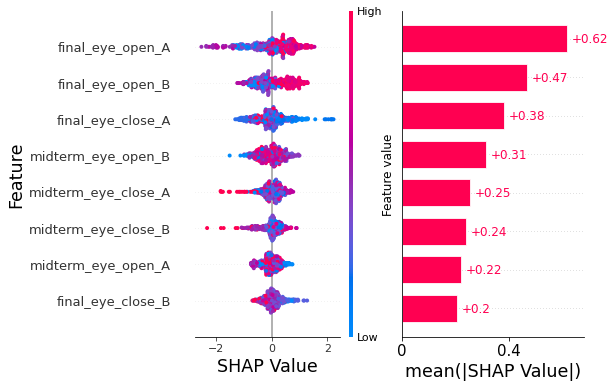

In [155]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(1, 2, 1)
shap.summary_plot(shap_values, model_set['X_test'], show=False)
plt.xlabel('SHAP Value',fontsize=fontsize_label/2,**csfont)
plt.ylabel('Feature',fontsize=fontsize_label/2,**csfont)
ax = plt.subplot(1, 2, 2)
shap.plots.bar(shap_values, max_display=20, show=False)
plt.ylabel('')
plt.yticks([])
plt.xlabel('mean(|SHAP Value|)',fontsize=fontsize_label/2,**csfont)
plt.xticks([0,0.4],['0','0.4'],fontsize=fontsize_tick/2,**csfont)
plt.savefig(file_path + f'/SHAP.png',dpi=600,bbox_inches='tight')

# SEM

### Define some para

In [40]:
main_path = '/data/xiaowei/social_network/HENU/'
folder_name = 'S42_C30_330_F1_40_N50_E2_Raverage'
method = 'PSD'
EEG_bands = dict(alpha = [8,14],beta = [14,30],theta = [4,8],gamma = [30,40],delta = [1,4])
file_path = '/data/xiaowei/social_network/HENU/figs_final/SEM'
create_folder(file_path)
epoch = get_fake_epoch(folder_name = folder_name,main_path = main_path,model_type = model_type)
ch_name = epoch.info['ch_names']

In [61]:
### Load data
data_path = main_path + 'EEG_features'+ f'/{folder_name}'
psd_path = [f for f in os.listdir(data_path) if f.endswith(f'_psd.pkl')]
used_id = np.unique([int(f.split('_')[3]) for f in psd_path])
relationship_survey = pd.read_excel(main_path + 'data/survey_data/Social_network_V2.xlsx',index_col=0)
surveys = pd.read_excel(main_path + 'data/survey_data/midterm.xlsx',index_col=0)
psds = {f[:-8]:loadpkl(data_path + '/'+f) for f in psd_path}
psd_idx = psds[list(psds.keys())[0]][1]
psds = {f:np.log(psds[f][0]) for f in psds.keys()}
sub_df = pd.read_csv(main_path + '/figs_final/feature_importance/S42_C30_330_F1_40_N50_E2_Raverage_XGBRegressor_PSD_187_ChannelSelect.csv')
print(sub_df)

     band channel  SHAP/Feature Importance
0   alpha     CP5                 0.013750
1   alpha     FT9                 0.009591
2   alpha      P3                 0.008118
3   alpha      Pz                 0.009474
4   alpha      T8                 0.006212
5   alpha     TP9                 0.005142
6    beta      C4                 0.006827
7    beta     CP2                 0.007570
8   delta     CP2                 0.011272
9   delta      Cz                 0.006642
10  delta     FC1                 0.005952
11  gamma      Cz                 0.007691
12  gamma      Fz                 0.005245
13  theta     CP1                 0.006378
14  theta      F8                 0.005116
15  theta     FC1                 0.007609
16  theta    TP10                 0.012533


In [64]:
# get P_EX,P_AG,P_CO,P_NE,P_OM,P_total,PD_Sociability,PD_Assetiveness,PD_EnegyLevel,PD_Compassion,PD_espectfulness,PD_Tust,PD_Oganization,PD_Poductiveness,PD_esponsibility,PD_Anxiety,PD_Depession,PD_EmotionalVolatility,PD_IntellectualCuiosity,PD_AestheticSensitivity,PD_CeativeImagination,PN_PA,PN_NA
P_col = ['P_EX','P_AG','P_CO','P_NE','P_OM']
personality = surveys[P_col]
personality.index = surveys['ID']
personality = personality.loc[used_id]
sub_df = pd.read_csv(main_path + '/figs_final/feature_importance/S42_C30_330_F1_40_N50_E2_Raverage_XGBRegressor_PSD_187_ChannelSelect.csv')
print(sub_df)

     band channel  SHAP/Feature Importance
0   alpha     CP5                 0.013750
1   alpha     FT9                 0.009591
2   alpha      P3                 0.008118
3   alpha      Pz                 0.009474
4   alpha      T8                 0.006212
5   alpha     TP9                 0.005142
6    beta      C4                 0.006827
7    beta     CP2                 0.007570
8   delta     CP2                 0.011272
9   delta      Cz                 0.006642
10  delta     FC1                 0.005952
11  gamma      Cz                 0.007691
12  gamma      Fz                 0.005245
13  theta     CP1                 0.006378
14  theta      F8                 0.005116
15  theta     FC1                 0.007609
16  theta    TP10                 0.012533


In [65]:

corr_df = pd.DataFrame(columns=['band','ch','event','corr','p'])
stat_df = []
for term in ['final','midterm']:
    for eye in ['eye_close','eye_open']:
        for ib,band in tqdm(enumerate(EEG_bands.keys()),desc = f"{term}_{eye}"):
            idx = (np.array(psd_idx>=EEG_bands[band][0],dtype = np.int32) * np.array(psd_idx<=EEG_bands[band][1],dtype = np.int32)) != 0
            for ich,ch in enumerate(sub_df['channel'].loc[sub_df['band']==band]):
                data = np.stack([psds[f'{term}_{eye}_{idx_s1}'][:,ich,idx].mean(0).mean(0) for idx_s1 in used_id])
                # corr
                for p in P_col:
                    stat = pg.corr(data,personality[p])
                    stat['band'] = band
                    stat['eye'] = eye
                    stat['term'] = term
                    stat['ch'] = ch
                    stat['Personality'] = p
                    stat_df.append(stat)

stat_df = pd.concat(stat_df,ignore_index=True,axis=0)
stat_df['h'],stat_df['p_correction'] = bonferroni_correction(stat_df['p-val'].to_numpy(),alpha=0.05)
stat_df.to_csv(file_path + f'/EEG_personality_corr.csv',index=False)             
print(stat_df['h'].sum())




final_eye_close: 5it [00:00, 12.53it/s]
final_eye_open: 5it [00:00, 14.56it/s]
midterm_eye_close: 5it [00:00, 14.55it/s]
midterm_eye_open: 5it [00:00, 14.63it/s]


0
